In [101]:
import numpy as  np
import pandas as pd
import os
from sklearn.metrics import mean_squared_error

# chainer関連
import chainer
from chainer import functions as F
from chainer.iterators import SerialIterator
from chainer.training.extensions import Evaluator
from chainer.datasets import split_dataset_random
from chainer_chemistry.dataset.parsers import CSVFileParser
from chainer_chemistry.dataset.converters import converter_method_dict
from chainer_chemistry.dataset.preprocessors import preprocess_method_dict
from chainer_chemistry.datasets import NumpyTupleDataset
from chainer_chemistry.links.scaler.standard_scaler import StandardScaler
from chainer_chemistry.models import Regressor
from chainer_chemistry.models.prediction import set_up_predictor
from chainer_chemistry.utils import run_train

# 作図関連
import seaborn as sns
from matplotlib import pyplot as plt

In [102]:
# 予測値の項目名、数を設定
labels = ['measured log(solubility:mol/L)']
class_num = len(labels) if isinstance(labels, list) else 1
class_num

1

In [103]:
# 予測方式のリスト
method_list = ['nfp', 'ggnn', 'schnet', 'weavenet', 'rsgcn', 'relgcn',
                   'relgat', 'mpnn', 'gnnfilm', 'megnet']

# 選択する予測方式
i = 0
method_list[i]

'nfp'

In [104]:
# トレーニングデータのCSVファイルの読み込み
def postprocess_label(label_list):
    return np.asarray(label_list, dtype=np.float32)


preprocessor = preprocess_method_dict[method_list[i]]()
parser = CSVFileParser(preprocessor, postprocess_label=postprocess_label,
                       labels=labels, smiles_col='SMILES')

dataset = parser.parse('trainval.csv')['dataset']

100%|██████████████████████████████████████████████████████████████████████████████| 915/915 [00:00<00:00, 2376.66it/s]


In [105]:
# 必要な場合は標準化を以下のように行う
scaler = StandardScaler()
scaler.fit(dataset.get_datasets()[-1])

In [106]:
# トレーニングとバリデーションのデータを分割
train_data_size = int(len(dataset) * 1)
train, _ = split_dataset_random(dataset, train_data_size, seed = 0)# 今回はバリデーションは行わない

In [107]:
# predictorのセットアップ
# n_unitはモデルのレイヤー数
predictor = set_up_predictor(
    method = method_list[0], n_unit = 16,
    conv_layers=6,class_num=class_num, label_scaler=scaler)

Set up NFP predictor...


In [108]:
# 条件の設定、device=-1 Numpy(CPU)で計算、+1でCupy(GPU)で計算
def rmse(x0, x1):
    return F.sqrt(F.mean_squared_error(x0, x1))

device = chainer.get_device(-1)
metrics_fun = {'mae': F.mean_absolute_error, 'rmse': rmse}
regressor = Regressor(predictor, lossfun=F.mean_squared_error,metrics_fun=metrics_fun, device=device)

In [109]:
# トレーニングの実施
converter_t = converter_method_dict[method_list[i]]
run_train(regressor, train, valid=None,
          batch_size=16, epoch=10,
          out='result', extensions_list=None,
          device=device, converter=converter_t,
          resume_path=None)


     total [..................................................]  1.75%
this epoch [########..........................................] 17.49%
        10 iter, 0 epoch / 10 epochs
       inf iters/sec. Estimated time to finish: 0:00:00.
     total [#.................................................]  3.50%
this epoch [#################.................................] 34.97%
        20 iter, 0 epoch / 10 epochs
    14.303 iters/sec. Estimated time to finish: 0:00:38.585148.
     total [##................................................]  5.25%
this epoch [##########################........................] 52.46%
        30 iter, 0 epoch / 10 epochs
    14.223 iters/sec. Estimated time to finish: 0:00:38.099578.
     total [###...............................................]  6.99%
this epoch [##################################................] 69.95%
        40 iter, 0 epoch / 10 epochs
    15.057 iters/sec. Estimated time to finish: 0:00:35.323561.
     total [####..................

In [110]:
# テストデータの読み込み
test = parser.parse('test.csv')['dataset']

100%|██████████████████████████████████████████████████████████████████████████████| 229/229 [00:00<00:00, 1861.37it/s]


In [111]:
# この辺参考
# https://github.com/chainer/chainer-chemistry/issues/362
if isinstance(test, NumpyTupleDataset):
    converter = converter_method_dict[method_list[i]]

    @chainer.dataset.converter()
    def extract_inputs(batch, device=None):
        return converter(batch, device=device)[:-1]

    # Extract the ground-truth labels as numpy array.
    original_t = converter(test, device=-1)[-1]
else:
    converter = test.converter
    extract_inputs = converter

    # Extract the ground-truth labels as numpy array.
    original_t = converter(test, device=-1).y

In [112]:
#データの予測
y_pred = regressor.predict(test, converter=extract_inputs,postprocess_fn=lambda x:x)

In [113]:
# 予測結果のdf作成
df_dict = {}
for i, l in enumerate(labels):
    df_dict.update({'y_pred_{}'.format(l): y_pred[:, i],
                    't_{}'.format(l): original_t[:, i], })
df = pd.DataFrame(df_dict)

# Show a prediction/ground truth table with 5 random examples.
df.head(10)

,y_pred_measured log(solubility:mol/L),t_measured log(solubility:mol/L)
0,-3.279569,-2.460
1,-4.821130,-2.850
2,-3.322173,-1.780
3,-3.050622,-0.410
4,-4.549259,-4.460
5,-4.646048,-1.601
6,-3.278482,-1.030
7,-3.732220,-3.380
8,-3.961792,-2.630
9,-2.755128,-0.820


[(-10, 2), (-10, 2)]

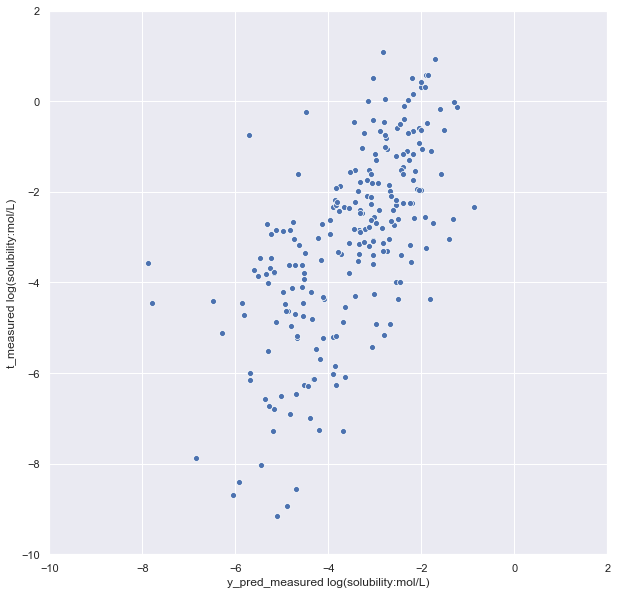

In [115]:
sns.set()
fig =plt.figure (figsize = (10,10))
ax = sns.scatterplot(x="y_pred_measured log(solubility:mol/L)", y="t_measured log(solubility:mol/L)", data=df)
ax.set(xlim=(-10,2), ylim=(-10,2))

In [ ]:
https://deepchem.io/docs/notebooks/solubility.html
https://pubs.acs.org/doi/10.1021/ci034243x